In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras import Input
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GRU, Bidirectional, LSTM
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model, to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Obtain final Amazon dataset.
data = pd.read_csv('../../data/results/amazon_final.csv')

In [ ]:
# Define dimensionality of word embeddings.
embedding_dim = 300

# Define max input length.
max_seq_len = 500

In [ ]:
# Encode emotion category.
data['PREDICTION'] = data['PREDICTION'].apply({'neutral':0, 'fear':1, 'sadness':2, 'joy':3,'anger':4}.get)
data

,REVIEW_TEXT,VERACITY,PREDICTION,joy,fear,neutral,anger,sadness
0,"When least you think so, this product will sav...",Fake,0,0.108776,0.035421,0.675116,0.196709,0.020431
1,Lithium batteries are something new introduced...,Fake,4,0.125708,0.103117,0.087749,0.627661,0.077903
2,I purchased this swing for my baby. She is 6 m...,Fake,0,0.261877,0.077076,0.413570,0.157695,0.113803
3,I was looking for an inexpensive desk calcolat...,Fake,1,0.107387,0.446936,0.163032,0.203908,0.093214
4,I m not sure what this is supposed to be but I...,Fake,0,0.229221,0.025874,0.672216,0.091756,0.014439
...,...,...,...,...,...,...,...,...
13980,These shoes are absolutely amazing. They are t...,Real,3,0.765827,0.011777,0.155121,0.068278,0.009005
13981,"My son had ordered it but when it arrived, he ...",Real,4,0.072390,0.062060,0.028264,0.771714,0.088904
13982,These shoes fit well. I purchased to wear to ...,Real,3,0.678554,0.028018,0.191851,0.054362,0.058558
13983,"These slippers are soft, warm, and very cozy. ...",Real,3,0.561892,0.037288,0.250742,0.157339,0.009371


In [ ]:
# Leave 10% of data for test set, and split training test into training and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(data[['REVIEW_TEXT', 'PREDICTION', 'joy', 'fear', 'neutral', 'anger', 'sadness']], data.VERACITY, test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15)

In [ ]:
# Obtain review texts for data and each data subset.
texts_train = X_train.REVIEW_TEXT.tolist()
texts_dev = X_dev.REVIEW_TEXT.tolist()
texts_test = X_test.REVIEW_TEXT.tolist()
texts = data.REVIEW_TEXT

In [ ]:
# Fit tokenizer on review texts.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_dev = tokenizer.texts_to_sequences(texts_dev)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Store the number of unique words (one added for padding).
vocab_size = len(index_of_words) + 1

In [ ]:
# Pad data.
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_dev_pad = pad_sequences(sequence_dev, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [ ]:
# Encode veracity predictions.
encoding = {
    'Fake': 0,
    'Real': 1,
}

y_train = [encoding[y] for y in y_train]
y_dev = [encoding[y] for y in y_dev]
y_test = [encoding[y] for y in y_test]

In [ ]:
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
# Obtain wiki vectors.
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Done.


In [ ]:
# Get embedding matrix.
embedding_matrix = create_embedding_matrix(fname, index_of_words, embedding_dim, vocab_size)
embedding_matrix.shape

(24935, 300)

In [ ]:
# Obtain emotion categories.
X_emo_train = X_train[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_dev = X_dev[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_test = X_test[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values

In [ ]:
# Define model input shapes.
input_text = Input(shape=(max_seq_len,))
input_emo = Input(shape=(6,))

### Obtain classification using text alone ###

In [ ]:
# Construct model.
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)
gru_layer = Bidirectional(GRU(128, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
dense_layer = Dense(128, activation='relu')(gru_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [ ]:
model_text = Model(inputs=input_text, outputs=output)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_text.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
print(model_text.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 300)          7480500   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,843,765
Trainable params: 363,265
Non-trainable params: 7,480,500
_________________________________________________________________
None


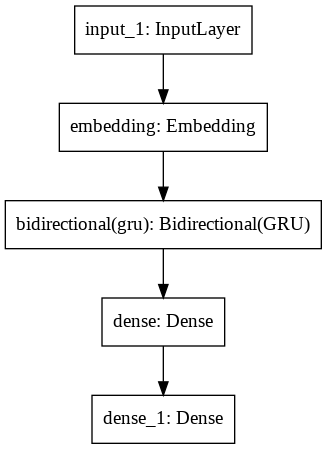

In [ ]:
plot_model(model_text, to_file='model_plot.png')

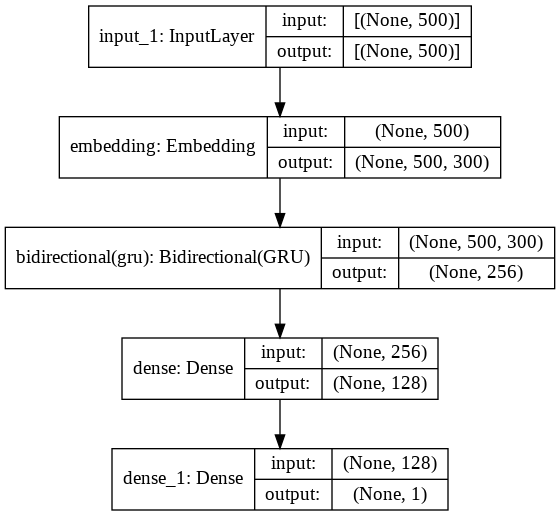

In [ ]:
plot_model(model_text, to_file='model_text.png', show_shapes=True)

In [ ]:
# Define stopping criteria and fit model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history_text = model_text.fit(x=X_train_pad, 
                              y=y_train, 
                              batch_size=64, 
                              epochs=50, 
                              verbose=1,
                              validation_data=(X_dev_pad, y_dev), 
                              callbacks=[early_stopping_monitor])

Epoch 1/50
168/168 [==============================] - 464s 3s/step - loss: 0.6914 - acc: 0.5248 - val_loss: 0.6893 - val_acc: 0.5339
Epoch 2/50
168/168 [==============================] - 462s 3s/step - loss: 0.6877 - acc: 0.5433 - val_loss: 0.6873 - val_acc: 0.5392
Epoch 3/50
168/168 [==============================] - 460s 3s/step - loss: 0.6821 - acc: 0.5566 - val_loss: 0.6808 - val_acc: 0.5546
Epoch 4/50
168/168 [==============================] - 458s 3s/step - loss: 0.6694 - acc: 0.5930 - val_loss: 0.6519 - val_acc: 0.6171
Epoch 5/50
168/168 [==============================] - 457s 3s/step - loss: 0.6418 - acc: 0.6273 - val_loss: 0.6588 - val_acc: 0.6075
Epoch 6/50
168/168 [==============================] - 459s 3s/step - loss: 0.6424 - acc: 0.6301 - val_loss: 0.6272 - val_acc: 0.6578
Epoch 7/50
168/168 [==============================] - 456s 3s/step - loss: 0.6404 - acc: 0.6340 - val_loss: 0.6363 - val_acc: 0.6372
Epoch 8/50
168/168 [==============================] - 459s 3s/step - 

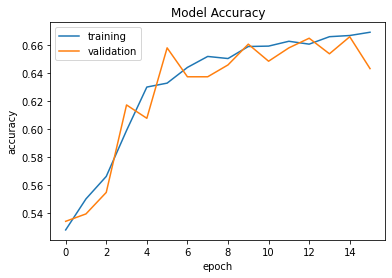

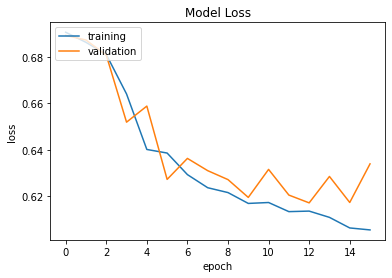

In [ ]:
# Plot accuracy and loss of the model.
plt.plot(history_text.history['acc'])
plt.plot(history_text.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history_text.history['loss'])
plt.plot(history_text.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Make predictions and record key metrics.
predictions = model_text.predict(X_test_pad)

In [ ]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [ ]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.6853    0.6421    0.6630       746
        Real     0.6186    0.6631    0.6401       653

    accuracy                         0.6519      1399
   macro avg     0.6519    0.6526    0.6515      1399
weighted avg     0.6541    0.6519    0.6523      1399



Text(0.5, 1.0, 'Veracity Predictions on Texts Alone')

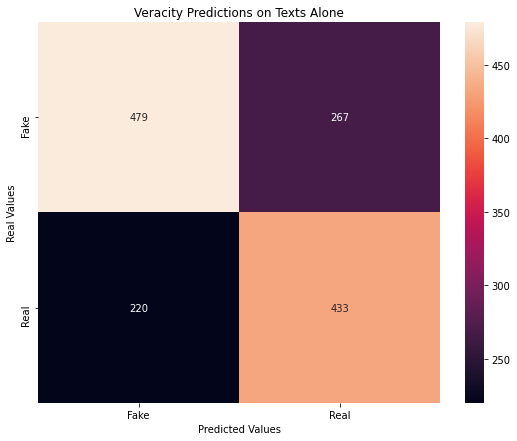

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions on Texts Alone')

In [ ]:
# Store model for future use.
model_text.save('../../trained_models/veracity_text_gru.h5')

### Obtain classification results on texts with emotions ###

In [ ]:
# Construct model.
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)
gru_layer = Bidirectional(GRU(128, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
concat_layer = Concatenate()([gru_layer, input_emo])
dense_layer = Dense(128, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [ ]:
model_emo = Model(inputs=[input_text, input_emo], outputs=output)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_emo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
print(model_emo.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     7480500     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          330240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
____________________________________________________________________________________________

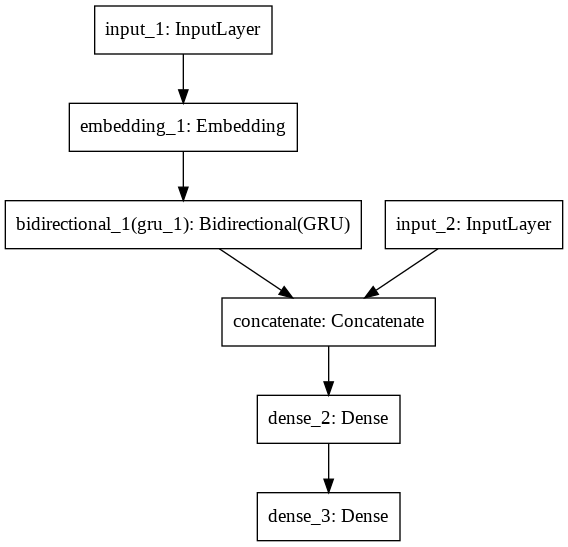

In [ ]:
plot_model(model_emo, to_file='model_emo_plot.png')

In [ ]:
# Define stopping criteria and fit model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history_emo = model_emo.fit(x=[X_train_pad, X_emo_train], 
                            y=y_train, 
                            batch_size=64, 
                            epochs=50, 
                            verbose=1,
                            validation_data=([X_dev_pad, X_emo_dev], y_dev), 
                            callbacks=[early_stopping_monitor])

Epoch 1/50
168/168 [==============================] - 461s 3s/step - loss: 0.7047 - acc: 0.4939 - val_loss: 0.6880 - val_acc: 0.5323
Epoch 2/50
168/168 [==============================] - 457s 3s/step - loss: 0.6866 - acc: 0.5443 - val_loss: 0.6852 - val_acc: 0.5540
Epoch 3/50
168/168 [==============================] - 459s 3s/step - loss: 0.6835 - acc: 0.5628 - val_loss: 0.6821 - val_acc: 0.5662
Epoch 4/50
168/168 [==============================] - 461s 3s/step - loss: 0.6756 - acc: 0.5785 - val_loss: 0.6614 - val_acc: 0.6017
Epoch 5/50
168/168 [==============================] - 463s 3s/step - loss: 0.6572 - acc: 0.6098 - val_loss: 0.6474 - val_acc: 0.6192
Epoch 6/50
168/168 [==============================] - 463s 3s/step - loss: 0.6448 - acc: 0.6200 - val_loss: 0.6381 - val_acc: 0.6329
Epoch 7/50
168/168 [==============================] - 459s 3s/step - loss: 0.6325 - acc: 0.6410 - val_loss: 0.6319 - val_acc: 0.6419
Epoch 8/50
168/168 [==============================] - 459s 3s/step - 

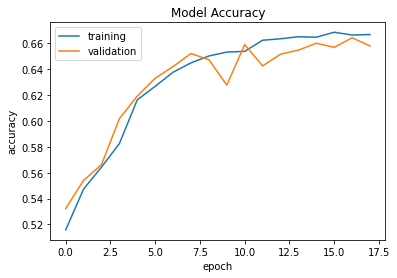

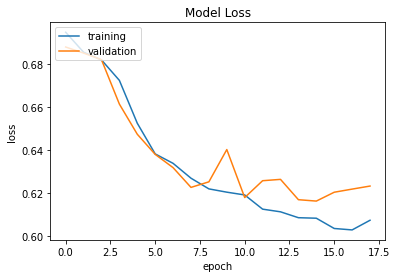

In [ ]:
# Plot accuracy and loss of the model.
plt.plot(history_emo.history['acc'])
plt.plot(history_emo.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history_emo.history['loss'])
plt.plot(history_emo.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Make predictions and record key metrics.
predictions = model_emo.predict([X_test_pad, X_emo_test])

In [ ]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [ ]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.6693    0.6729    0.6711       746
        Real     0.6240    0.6202    0.6221       653

    accuracy                         0.6483      1399
   macro avg     0.6467    0.6466    0.6466      1399
weighted avg     0.6482    0.6483    0.6483      1399



Text(0.5, 1.0, 'Veracity Predictions on Texts with Emotions')

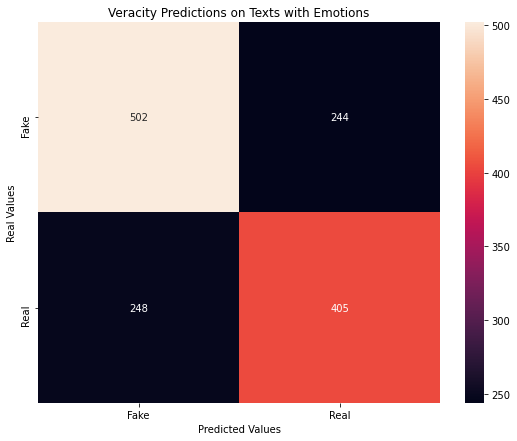

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions on Texts with Emotions')

In [ ]:
# Store model for future use.
model_text.save('../../trained_models/veracity_text_emo_gru.h5')